In [23]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D,LeakyReLU ,Concatenate, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from skimage.color import rgb2lab

In [51]:
# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 64
resolution = (64, 64)

# These many images will be used from the data archive
dataset_split = 10000

photos_path = './imagenet/all_kinds'
# photos_path = './imagenet/pomegranate/train'

train_split = 0.8
random_seed = 42

photos = []
for photo_name in os.listdir(photos_path):
    photo = load_img(os.path.join(photos_path, photo_name))
    photo = photo.resize(resolution)
    photo_array = img_to_array(photo)
    photos.append(photo_array)

photos_np = np.array(photos, dtype=float)
photos_np /= 255.0

LAB_images = rgb2lab(photos_np)
X = LAB_images[:, :, :, 0]
y = np.array(photos_np)


train_x, test_x, train_y, test_y = train_test_split(
    X, y, train_size=train_split, random_state=random_seed)

data_tensor = tf.data.Dataset.from_tensor_slices((train_x, train_y))
data_tensor = data_tensor.batch(batch_size)


In [52]:
train_x.shape

(8000, 64, 64)

In [ ]:
activation_hidden = 'relu'
activation_output = 'sigmoid'
small_filter = (3,3)
med_filter = (5,5)
large_filter = (7,7)
lr = 0.001

In [53]:
def build_generator():
    inputs = Input(shape=(img_size, img_size, 1))
    conv1 = Conv2D(16, kernel_size=med_filter, strides=1)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(32, kernel_size=small_filter, strides=1)(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(32, kernel_size=small_filter, strides=1)(conv1)
    conv1 = LeakyReLU()(conv1)
    conv2 = Conv2D(32, kernel_size=med_filter, strides=1)(conv1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(64, kernel_size=small_filter, strides=1)(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(64, kernel_size=small_filter, strides=1)(conv2)
    conv2 = LeakyReLU()(conv2)
    conv3 = Conv2D(64, kernel_size=med_filter, strides=1)(conv2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(128, kernel_size=small_filter, strides=1)(conv3)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(128, kernel_size=small_filter, strides=1)(conv3)
    conv3 = LeakyReLU()(conv3)
    bottleneck = Conv2D(128, kernel_size=small_filter, strides=1, activation=activation_hidden, padding='same')(conv3)
    concat_1 = Concatenate()([bottleneck, conv3])
    conv_up_3 = Conv2DTranspose(128, kernel_size=small_filter, strides=1, activation=activation_hidden)(concat_1)
    conv_up_3 = Conv2DTranspose(128, kernel_size=small_filter, strides=1, activation=activation_hidden)(conv_up_3)
    conv_up_3 = Conv2DTranspose(64, kernel_size=med_filter, strides=1, activation=activation_hidden)(conv_up_3)
    concat_2 = Concatenate()([conv_up_3, conv2])
    conv_up_2 = Conv2DTranspose(64, kernel_size=small_filter, strides=1, activation=activation_hidden)(concat_2)
    conv_up_2 = Conv2DTranspose(64, kernel_size=small_filter, strides=1, activation=activation_hidden)(conv_up_2)
    conv_up_2 = Conv2DTranspose(32, kernel_size=med_filter, strides=1, activation=activation_hidden)(conv_up_2)
    concat_3 = Concatenate()([conv_up_2, conv1])
    conv_up_1 = Conv2DTranspose(32, kernel_size=small_filter, strides=1, activation=activation_hidden)(concat_3)
    conv_up_1 = Conv2DTranspose(32, kernel_size=small_filter, strides=1, activation=activation_hidden)(conv_up_1)
    conv_up_1 = Conv2DTranspose(3, kernel_size=med_filter, strides=1, activation=activation_hidden)(conv_up_1)
    model = tf.keras.models.Model(inputs, conv_up_1)
    print(model.summary())
    return model


In [54]:

def build_discriminator():
    layers = [
        tf.keras.layers.Conv2D(32, kernel_size=large_filter, padding='same', strides=1,
                               activation=activation_hidden, input_shape=(img_size, img_size, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=large_filter,
                               padding='same', strides=1, activation=activation_hidden),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, kernel_size=med_filter,
                               padding='same', strides=1, activation=activation_hidden),
        tf.keras.layers.Conv2D(64, kernel_size=med_filter,
                               padding='same', strides=1, activation=activation_hidden),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, kernel_size=small_filter,
                               padding='same', strides=1, activation=activation_hidden),
        tf.keras.layers.Conv2D(128, kernel_size=small_filter,
                               padding='same', strides=1, activation=activation_hidden),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, kernel_size=small_filter,
                               padding='same', strides=1, activation=activation_hidden),
        tf.keras.layers.Conv2D(256, kernel_size=small_filter,
                               padding='same', strides=1, activation=activation_hidden),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=activation_hidden),
        tf.keras.layers.Dense(128, activation=activation_hidden),
        tf.keras.layers.Dense(16, activation=activation_hidden),
        tf.keras.layers.Dense(1, activation=activation_output)
    ]
    model = tf.keras.models.Sequential(layers)
    print(model.summary())
    return model


In [55]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def get_loss_disc(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(
        real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1), real_output)
    generator_loss = cross_entropy(tf.zeros_like(
        fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1), fake_output)
    total_loss = real_loss + generator_loss
    return total_loss

def get_loss_gen(generator_output, real_y):
    real_y = tf.cast(real_y, 'float32')
    return mse(generator_output, real_y)

optimizer_generator = tf.keras.optimizers.Adam(lr)
optimizer_discriminator = tf.keras.optimizers.Adam(lr)
model_generator = build_generator()
model_discriminator = build_discriminator()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 60, 60, 16)   416         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 60, 60, 16)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 58, 58, 32)   4640        leaky_re_lu_18[0][0]             
____________________________________________________________________________________________

In [56]:

@tf.function
def train_step(input_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = model_generator(input_x, training=True)
        # print('after generator 1')
        real_output = model_discriminator(real_y, training=True)
        # print('after discriminator 1')
        generated_output = model_discriminator(generated_images, training=True)
        # print('after discriminator 2')
        gen_loss = get_loss_gen(generated_images, real_y)
        disc_loss = get_loss_disc(real_output, generated_output)
        # print('after loss')
    generator_gradients = gen_tape.gradient(gen_loss, model_generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, model_discriminator.trainable_variables)
    optimizer_generator.apply_gradients(zip(generator_gradients, model_generator.trainable_variables))
    optimizer_discriminator.apply_gradients(zip(discriminator_gradients, model_discriminator.trainable_variables))


In [57]:
!pip install tqdm
from tqdm import tqdm

In [71]:
epochs = 100
for epoch in range(epochs):
    for (x, y) in tqdm(data_tensor, desc=f"steps for epoch {epoch}"):
        train_step(x, y)

steps for epoch 99: 100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


In [ ]:
model_generator.save_weights(f"gan_generator_imagenet_{epochs}.h5")
model_discriminator.save_weights(f"gan_discriminator_imagenet_{epochs}.h5")

In [94]:
# generate all test images
generated_y = []
batch_size = 50
for batch in range(batch_size, len(test_x)+batch_size, batch_size):
    batched_x = test_x[batch - batch_size: batch]
    batched_y = model_generator(np.asarray(batched_x)).numpy()
    generated_y.extend(batched_y)

# get original images
original_y = np.asarray(test_y)

len(original_y), len(generated_y)

(2000, 2000)

In [ ]:
! pip install image-similarity-measures
from image_similarity_measures.quality_metrics import rmse, psnr, ssim, fsim, uiq

In [102]:
from numba import jit, cuda
import pandas as pd

@jit(target_backend='cuda')
def get_all_images(generated_y, original_y):
    all_images = {
        'original':[],
        'generated':[],
        'rmse':[],
        'psnr':[],
        'fsim':[],
        'uiq':[],
    }

    for generated, original in tqdm(zip(generated_y, original_y)):
        og_img = np.array(original)
        og_img = 1.0 / 255 *np.asarray(og_img)
        col_img = np.array(generated)
        col_img = 1.0 / 255 *np.asarray(col_img)

        img_rmse = rmse(og_img, col_img)
        img_psnr = psnr(og_img, col_img)
        img_fsim = fsim(og_img, col_img)
        img_uiq = uiq(og_img, col_img)
        # img_rmse, img_psnr, img_fsim, img_uiq = get_image_metrics(og_img, col_img)
        all_images['original'].append(original)
        all_images['generated'].append(generated)
        all_images['rmse'].append(img_rmse)
        all_images['psnr'].append(img_psnr)
        all_images['fsim'].append(img_fsim)
        all_images['uiq'].append(img_uiq)
    return all_images

# all_images = get_all_images(generated_y, original_y)

# df = pd.DataFrame(all_images)
# df.head()

C:\Users\Soham\AppData\Local\Temp\ipykernel_22608\1489898061.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_all_images" failed type inference due to: Untyped global name 'tqdm': Cannot determine Numba type of <class 'type'>

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_22608\1489898061.py", line 15:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
C:\Users\Soham\AppData\Local\Temp\ipykernel_22608\1489898061.py:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_all_images" failed type inference due to: Untyped global name 'tqdm': Cannot determine Numba type of <class 'type'>

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_22608\1489898061.py", line 15:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
d:\ProgramData\Anaconda3\envs\kewlar\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "

,original,generated,rmse,psnr,fsim,uiq
0,"[[[0.06274509803921569, 0.0784313725490196, 0....","[[[0.21797939, 0.19623034, 0.20296253], [0.150...",8.099337e-08,141.831012,0.980475,0.872516
1,"[[[0.5137254901960784, 0.41568627450980394, 0....","[[[0.41259503, 0.3837749, 0.34950396], [0.4768...",5.486831e-08,145.213571,0.993195,0.875569
2,"[[[0.3607843137254902, 0.403921568627451, 0.42...","[[[0.31048614, 0.27755833, 0.23804952], [0.327...",6.542236e-08,143.685479,0.991386,0.940206
3,"[[[0.39215686274509803, 0.3686274509803922, 0....","[[[0.46774587, 0.44026196, 0.4007804], [0.5101...",6.661422e-08,143.528662,0.989594,0.937743
4,"[[[0.807843137254902, 0.6980392156862745, 0.55...","[[[0.6527038, 0.62319624, 0.5575974], [0.69003...",7.613668e-08,142.368121,0.986120,0.815049


In [2]:
uiq_df = df.sort_values(by='uiq', ascending=False)
uiq_df.head()

,Unnamed: 0,original,generated,rmse,psnr,fsim,uiq
1293,1293,[[[0.69803922 0.69803922 0.72941176]\n [0.752...,[[[0.6623294 0.66158146 0.6436583 ]\n [0.721...,4.757312e-08,146.452765,0.997662,0.987133
644,644,[[[0.34509804 0.40392157 0.32941176]\n [0.247...,[[[0.3298764 0.36283314 0.43568775]\n [0.338...,4.517560e-08,146.901922,0.995864,0.983562
1663,1663,[[[0.61960784 0.5254902 0.47843137]\n [0.690...,[[[0.5069926 0.48073754 0.43542856]\n [0.662...,3.749565e-08,148.520384,0.998434,0.983377
1521,1521,[[[0.2 0.15294118 0.09803922]\n [0.250...,[[[0.14274274 0.11079867 0.10258298]\n [0.145...,3.260610e-08,149.734025,0.996052,0.982211
1587,1587,[[[0.89019608 0.74509804 0.68235294]\n [0.631...,[[[0.65459484 0.648413 0.6023843 ]\n [0.675...,4.768207e-08,146.432896,0.995930,0.981945


In [3]:
all_sorted_df = df.sort_values(by=['uiq', 'fsim', 'psnr', 'rmse'], ascending=False)
all_sorted_df.head()

,Unnamed: 0,original,generated,rmse,psnr,fsim,uiq
1293,1293,[[[0.69803922 0.69803922 0.72941176]\n [0.752...,[[[0.6623294 0.66158146 0.6436583 ]\n [0.721...,4.757312e-08,146.452765,0.997662,0.987133
644,644,[[[0.34509804 0.40392157 0.32941176]\n [0.247...,[[[0.3298764 0.36283314 0.43568775]\n [0.338...,4.517560e-08,146.901922,0.995864,0.983562
1663,1663,[[[0.61960784 0.5254902 0.47843137]\n [0.690...,[[[0.5069926 0.48073754 0.43542856]\n [0.662...,3.749565e-08,148.520384,0.998434,0.983377
1521,1521,[[[0.2 0.15294118 0.09803922]\n [0.250...,[[[0.14274274 0.11079867 0.10258298]\n [0.145...,3.260610e-08,149.734025,0.996052,0.982211
1587,1587,[[[0.89019608 0.74509804 0.68235294]\n [0.631...,[[[0.65459484 0.648413 0.6023843 ]\n [0.675...,4.768207e-08,146.432896,0.995930,0.981945


<AxesSubplot: ylabel='Frequency'>

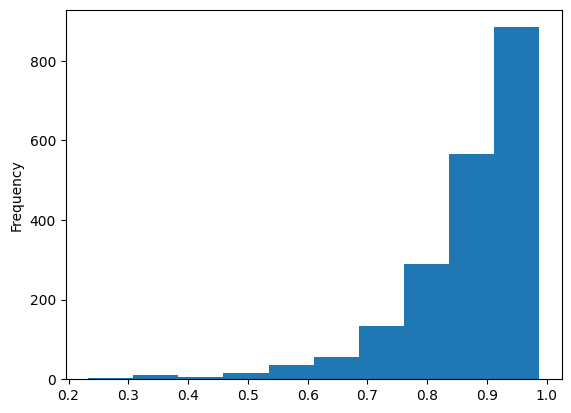

In [8]:
all_sorted_df['uiq'].plot(kind='hist')

In [21]:
import random
other_df = all_sorted_df[(all_sorted_df['uiq'] > 0.64) & (all_sorted_df['uiq'] < 0.72)]
idx_samples = random.sample(list(other_df.index), 5)
sample_df = df[df.index.isin(idx_samples)]
sample_df

,Unnamed: 0,original,generated,rmse,psnr,fsim,uiq
5,5,[[[0.56078431 0.48235294 0.45490196]\n [0.568...,[[[0.4501998 0.43301865 0.41200116]\n [0.482...,6.735403e-08,143.432727,0.983345,0.707882
207,207,[[[0.51764706 0.51764706 0.48627451]\n [0.545...,[[[0.4500925 0.49284855 0.57318157]\n [0.445...,6.950344e-08,143.159871,0.961961,0.660632
726,726,[[[0.80784314 0.74901961 0.43137255]\n [0.854...,[[[0.5864728 0.5521196 0.48330656]\n [0.678...,1.284617e-07,137.824526,0.957696,0.692161
770,770,[[[0.16470588 0.18431373 0.4 ]\n [0.164...,[[[0.18808354 0.15247831 0.1369889 ]\n [0.217...,1.472703e-07,136.637697,0.963884,0.682144
1613,1613,[[[0.01960784 0.01176471 0. ]\n [0.011...,[[[0.19450012 0.1890693 0.22819062]\n [0.086...,2.261746e-07,132.911124,0.935335,0.703766


In [ ]:
render_resolution = (512, 512)
import matplotlib.pyplot as plt
import random

for i, row in sample_df.iterrows():
    f, axarr = plt.subplots(1,3)
    colorized = Image.fromarray((row['generated'] * 255).astype('uint8')).resize(render_resolution)
    # colorized = np.asarray(colorized)
    original = Image.fromarray((row['original'] * 255).astype('uint8')).resize(render_resolution)
    greyscale = Image.fromarray((test_x[int(row.name)]).astype('uint8')).resize(render_resolution)
    axarr[0].imshow(original)
    axarr[1].imshow(colorized)
    axarr[2].imshow(np.asarray(greyscale), cmap='gray')

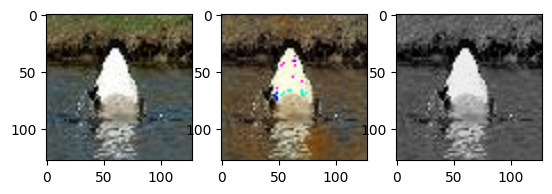

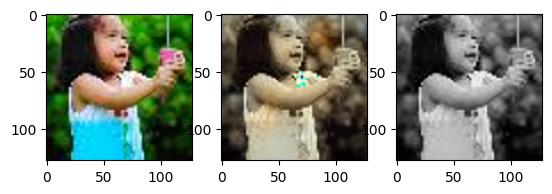

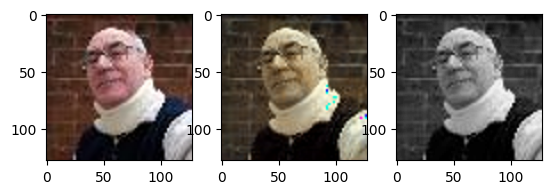

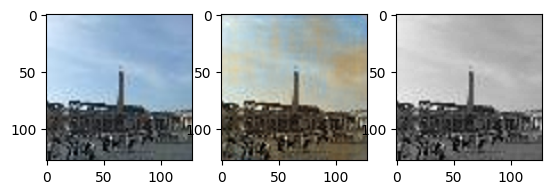

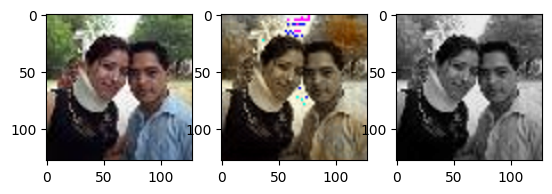

In [79]:
render_resolution = (128, 128)
import matplotlib.pyplot as plt
import random

sample_lenght = 5
samples = random.sample(range(len(test_x)),sample_lenght)

y = model_generator(np.array(test_x)[samples]).numpy()

# y = generator(test_x[0: 25]).numpy()
# samples = random.sample(range(25), 3 )
for i, sample in enumerate(samples):
    f, axarr = plt.subplots(1,3)
    colorized = Image.fromarray((y[i] * 255).astype('uint8')).resize(render_resolution)
    colorized = np.asarray(colorized)
    original = Image.fromarray((test_y[sample] * 255).astype('uint8')).resize(render_resolution)
    grayscale = Image.fromarray((test_x[sample] ).astype('uint8')).resize(render_resolution)
    axarr[0].imshow(original)
    axarr[1].imshow(colorized)
    axarr[2].imshow(np.asarray(grayscale), cmap='gray')
